In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import scipy.signal
from scipy.signal import correlate

import requests
from sklearn.cluster import KMeans
from PIL import Image
from io import BytesIO
from google.colab.patches import cv2_imshow

# **Q4** Optical Character Recognition

In [ ]:
# Function to read image from URL
def read_image(url):
    response = requests.get(url)
    img = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    return img

# Function to extract lines of text from the image
def extract_lines(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding to get binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Define a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)
    # Dilate the binary image to connect nearby contours
    dilated = cv2.dilate(binary, kernel, iterations=1)
    # Find contours of text lines
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store extracted text lines
    text_lines = []
    # Iterate through contours
    for contour in contours:
        # Get bounding box coordinates of contour
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out small contours (likely noise)
        if h > 10:
            # Extract text line from original image using bounding box
            text_lines.append(image[y:y+h, x:x+w])

    return text_lines

# Function to segment characters from a text line
def segment_characters(text_line):
    # Convert text line to grayscale
    gray = cv2.cvtColor(text_line, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding to get binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Define a kernel for morphological operations
    kernel = np.ones((2, 2), np.uint8)
    # Dilate the binary image to connect nearby contours
    dilated = cv2.dilate(binary, kernel, iterations=1)
    # Find contours of characters
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store segmented characters
    characters = []
    # Iterate through contours
    for contour in contours:
        # Get bounding box coordinates of contour
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out small contours (likely noise)
        if h > 10 and w > 5:
            # Check if the contour has significant width compared to height
            if w > h * 1.2:
                # Split the contour horizontally into smaller segments
                num_splits = max(2, int(w / h))
                segment_width = int(w / num_splits)
                for i in range(num_splits):
                    # Extract character segment from text line
                    character = text_line[y:y+h, x+i*segment_width:x+(i+1)*segment_width]
                    characters.append(character)
            else:
                # Extract character from text line
                character = text_line[y:y+h, x:x+w]
                characters.append(character)

    return characters

# Function to resize all characters to the same dimensions
def resize_characters(characters, target_size=(30, 30)):
    resized_characters = []
    # Iterate through characters
    for character in characters:
        # Resize character to target size
        resized = cv2.resize(character, target_size, interpolation=cv2.INTER_AREA)
        resized_characters.append(resized)
    return resized_characters

# Function to flatten characters into 1D arrays
def flatten_characters(characters):
    flattened_characters = []
    # Iterate through characters
    for character in characters:
        # Flatten character into 1D array
        flattened = character.flatten()
        flattened_characters.append(flattened)
    return np.array(flattened_characters)

In [ ]:
# URL of the image
image1_url = "https://www.atomicarchive.com/img/documents/orig_593374_4394.jpg"
image2_url = "https://www.atomicarchive.com/img/documents/orig_593374_4395.jpg"

# Read the image from URL
image_1 = read_image(image1_url)
image_2 = read_image(image2_url)

# Extract text lines from the image
text_lines = extract_lines(image_1)
text_lines = extract_lines(image_2)

In [ ]:
# Segment individual characters from text lines
all_characters = []
for text_line in text_lines:
    characters_1 = segment_characters(text_line)
    all_characters.extend(characters_1)

for text_line in text_lines:
    characters_2 = segment_characters(text_line)
    all_characters.extend(characters_2)

In [ ]:
# Resize all characters to the same dimensions
resized_characters = resize_characters(all_characters)

# Flatten characters into 1D arrays
flattened_characters = flatten_characters(resized_characters)

In [ ]:
# Use K-means clustering to identify 30 clusters of characters
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(flattened_characters)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=30, random_state=42)

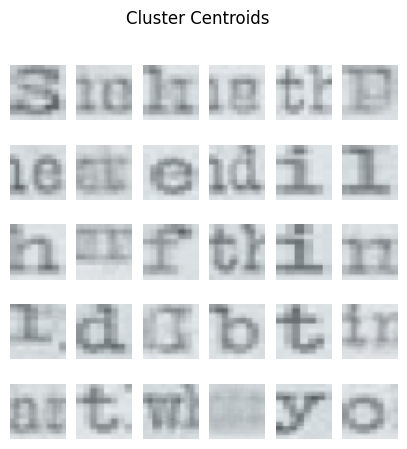

In [ ]:
# Display the cluster centers (representative alphabets) in a 5x6 grid
num_clusters = 30
cluster_centers = kmeans.cluster_centers_.copy()
np.random.shuffle(cluster_centers)
fig, axes = plt.subplots(5, 6, figsize=(5, 5))
plt.suptitle('Cluster Centroids')
for i, ax in enumerate(axes.flat):
    if i < num_clusters:
        alphabet = cluster_centers[i].reshape((30, 30, 3)).astype(np.uint8)
        ax.imshow(alphabet)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for empty subplots

plt.show()